First, Compile a list of all chandra sources that could possibly be in PASSAGE (within 3 arcmin of the center)

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.coordinates as coord
from astroquery.heasarc import Heasarc
from astropy.utils.data import download_file
import astropy.units as u
import pandas as pd
from astroquery.vizier import Vizier
import astropy.table as tab

In [23]:
check_radius=0.05*u.deg #=3 arcmin
catalog_names = {'chandra':'csc',
                 'xmm':'xmmssc'}
                 
par_coords_import=np.loadtxt('./par_coords.csv',dtype='str',delimiter=',')
par_coords_list=coord.SkyCoord(ra=par_coords_import[:,1],dec=par_coords_import[:,2],unit=(u.deg, u.deg))
par_names=par_coords_import[:,0]

In [ ]:
df_counts=pd.DataFrame(columns=catalog_names.keys(),index=par_names)

#identifying number of objects in each field for chandra and xmm

for j in range(len((catalog_names.values()))):
    print(list(catalog_names.values())[j]+'\n')

    column_counts=np.zeros(len(par_coords_list))

    for i in range(len(par_coords_list)):

            current_par=par_names[i]

            print(current_par+'\n')

            #query chandra
            result = Heasarc.query_region(par_coords_list[i],catalog=list(catalog_names.values())[j],radius=check_radius)

            if len(result) > 0:
                column_counts[i]=len(result)
            else:
                print("Nothing found for "+ current_par)
                continue

    df_counts[list(catalog_names.keys())[j]]=column_counts

In [24]:
print(df_counts)
print(sum(df_counts['chandra']),sum(df_counts['xmm']))

        chandra   xmm
Par001      4.0  31.0
Par002     13.0  16.0
Par003     19.0  36.0
Par004      2.0   0.0
Par005     18.0  16.0
...         ...   ...
Par059      4.0  34.0
Par060     17.0  14.0
Par061      0.0   7.0
Par062      0.0   0.0
Par063      3.0   5.0

[63 rows x 2 columns]
406.0 876.0


In [ ]:
lrd_counts=np.zeros(len(par_coords_list))

for i in range(len(par_coords_list)):

    current_par=par_names[i]

    print(current_par+'\n')

    #query chandra
    result = Vizier.query_region(par_coords_list[i],catalog='J/A+A/693/L2',radius=check_radius)

    if len(result) > 0:
        print(len(result[0]))
        lrd_counts[i]=len(result[0])
    else:
        print("Nothing found for "+ current_par)
        continue

df_counts['lrd']=lrd_counts

Now that we know how many observations are in each field for both csc2.1 and xmmssc dr14, our next step is to actually extract their parameters, while appending an extra column that says the par they were discovered in. Chandra first - LOOK AT VIZIER FOR WHICH COLUMNS YOU NEED TO KEEP, sig, error ellipse, etc, maybe major fluxes

In [ ]:
#do the first one outside the loop

chan_cols='name,ra,dec,significance,error_ellipse_r0,error_ellipse_r1,error_ellipse_angle'

for i in range(len(par_coords_list)):
    
    #we already did the first one
    if i==0:
        csc_table=Heasarc.query_region(par_coords_list[i],catalog='csc',radius=check_radius,columns=chan_cols)
        add_col=tab.Column(np.repeat(par_names[i],len(csc_table)),name='par_name')
        csc_table.add_column(add_col)
        continue
    current_par=par_names[i]
    add_table=Heasarc.query_region(par_coords_list[i],catalog='csc',radius=check_radius,columns=chan_cols)
    add_col=tab.Column(np.repeat(par_names[i],len(add_table)),name='par_name')
    add_table.add_column(add_col)
    csc_table=tab.vstack([csc_table,add_table])

print(csc_table)

In [51]:
#do the first one outside the loop

xmm_cols='detid, srcid, name, src_num, obsid, ra, dec, error_radius, ep_extent, ep_extent_error, ep_extent_ml, sc_ra, sc_dec, sc_poserr, sc_det_ml'

for i in range(len(par_coords_list)):
    
    #we already did the first one
    if i==0:
        xmm_table=Heasarc.query_region(par_coords_list[i],catalog='xmmssc',radius=check_radius,columns=xmm_cols)
        add_col=tab.Column(np.repeat(par_names[i],len(xmm_table)),name='par_name')
        xmm_table.add_column(add_col)
        continue
    current_par=par_names[i]
    add_table=Heasarc.query_region(par_coords_list[i],catalog='xmmssc',radius=check_radius,columns=xmm_cols)
    add_col=tab.Column(np.repeat(par_names[i],len(add_table)),name='par_name')
    add_table.add_column(add_col)
    xmm_table=tab.vstack([xmm_table,add_table])

print(xmm_table)


    


     detid           srcid               name         ... sc_det_ml par_name
                                                      ...                   
--------------- --------------- --------------------- ... --------- --------
106939903015035 206939901010018 4XMM J112008.5+063405 ...    356.99   Par001
108849904010129 206939902015162 4XMM J112011.6+063417 ...    20.004   Par001
106939902010003 206939901010002 4XMM J112014.8+063341 ...    5756.5   Par001
106939901010002 206939901010002 4XMM J112014.8+063341 ...    5756.5   Par001
106939902010158 206939902010158 4XMM J112005.6+063733 ...    7.8045   Par001
106939902010101 206939902010101 4XMM J112015.2+063654 ...    20.465   Par001
106939903010045 206939901010044 4XMM J112006.7+063351 ...    142.67   Par001
106939901010088 206939901010088 4XMM J112009.8+063337 ...    9.3716   Par001
106939902010013 206939901010010 4XMM J111959.5+063641 ...    1038.9   Par001
            ...             ...                   ... ...       ...      ...

In [49]:
len(set(xmm_table['srcid'])),len(set(xmm_table['obsid']))

(81, 21)

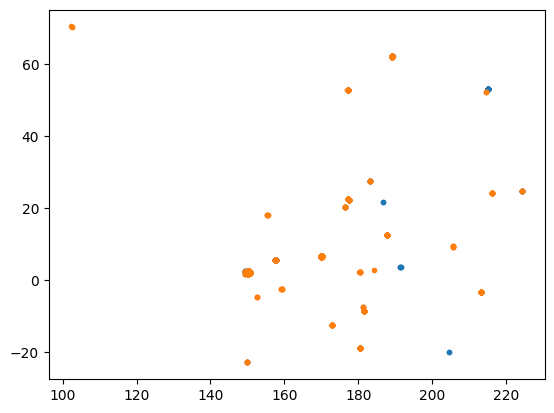

In [55]:
plt.figure()
plt.plot(csc_table['ra'],csc_table['dec'],'.')
plt.plot(xmm_table['ra'],xmm_table['dec'],'.')
plt.show()

xmm_unique_table=tab.unique(xmm_table,keys='srcid')

chan_coords=coord.SkyCoord(ra=csc_table['ra'],dec=csc_table['dec'],unit=(u.deg, u.deg))
xmm_coords=coord.SkyCoord(ra=xmm_unique_table['sc_ra'],dec=xmm_unique_table['sc_dec'],unit=(u.deg, u.deg))

chan_match_idx, d2d, d3d = chan_coords.match_to_catalog_sky(xmm_coords,)

match_radius=3*u.arcsec
dist_mask=d2d<match_radius


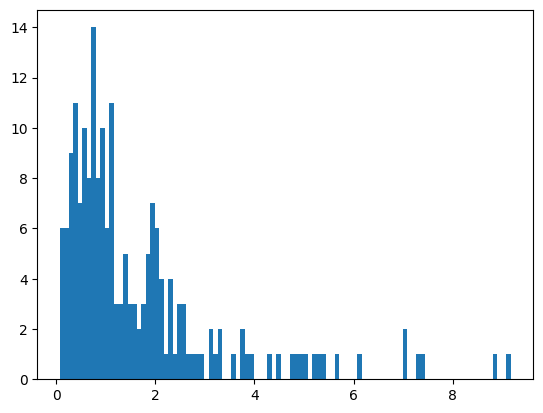

In [59]:
plt.figure()
plt.hist(d2d.arcsec[d2d<10*u.arcsec],bins=100)
plt.show()